# Feature Comparison Analysis

This notebook loads X_test data, preprocesses it, and compares which variables were selected by each feature set.

## Overview
- Load and preprocess X_test data
- Load all feature sets from JSON files
- Create comparison tables showing which features are used by each feature set
- Analyze feature overlap and uniqueness across different approaches


In [18]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

print("Libraries imported")


Libraries imported


In [19]:
# Configuration
FEATURE_SETS_DIR = "../feature_sets"
DATA_DIR = "../data"  # Adjust if needed

print(f"Feature Sets Directory: {FEATURE_SETS_DIR}")
print(f"Data Directory: {DATA_DIR}")

# Verify directories exist
if os.path.exists(FEATURE_SETS_DIR):
    feature_files = [f for f in os.listdir(FEATURE_SETS_DIR) if f.endswith('.json')]
    print(f"Found {len(feature_files)} feature set files:")
    for f in feature_files:
        print(f"  - {f}")
else:
    print(f"Warning: Feature sets directory not found at {FEATURE_SETS_DIR}")


Feature Sets Directory: ../feature_sets
Data Directory: ../data
Found 14 feature set files:
  - rfecv_all_nfeat_152_nonpca_count_loc.json
  - rfecv_all_nfeat_60_pca_count_loc.json
  - rfecv_img_cols_nfeat_104_nonpca_count_loc.json
  - rfecv_all_nfeat_70_nonpca_count_loc.json
  - elasticnet_all_cv_pca_scaled_count_loc.json
  - elasticnet_img_cols_cv_nonpca_scaled_count_loc.json
  - elasticnet_all_cv_nonpca_scaled_count_loc.json
  - rfecv_all_nfeat_80_nonpca_count.json
  - rfecv_all_nfeat_60_pca_count.json
  - rfecv_base_poi_pano_nfeat_160_nonpca_count_loc.json
  - rfecv_base_nfeat_117_nonpca_count_loc.json
  - comb_all_nfeat_201_pca_count_loc.json
  - rfecv_img_cols_nfeat_41_nonpca_count_loc.json
  - rfecv_all_nfeat_71_pca_count_loc.json


In [20]:
def load_feature_set(filepath):
    """Load a feature set from JSON file"""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def extract_feature_set_name(filename):
    """Extract a clean name from the feature set filename"""
    # Remove .json extension
    name = filename.replace('.json', '')
    # Extract key parts for readability
    parts = name.split('_')
    
    # Build readable name
    readable_parts = []
    for i, part in enumerate(parts):
        if part == 'rfecv':
            pass
            #readable_parts.append('RFECV')
        elif part in ['base', 'all']:
            readable_parts.append(part.upper())
        elif part.startswith('nfeat'):
            pass
            #readable_parts.append(f"({part.replace('nfeat_', '')} features)")
        elif part in ['pca', 'nonpca']:
            readable_parts.append(part.upper())
        elif part in ['count', 'loc']:
            readable_parts.append(part.upper())
        elif part in ['poi', 'pano']:
            readable_parts.append(part.upper())
        else:
            readable_parts.append(str(part).upper())
    
    return ' '.join(readable_parts)

# Load all feature sets
feature_sets = {}
feature_set_files = [f for f in os.listdir(FEATURE_SETS_DIR) if f.endswith('.json')]

for filename in feature_set_files:
    filepath = os.path.join(FEATURE_SETS_DIR, filename)
    feature_set = load_feature_set(filepath)
    
    if feature_set:
        readable_name = extract_feature_set_name(filename)
        feature_sets[readable_name] = {
            'filename': filename,
            'selected_features': feature_set.get('selected_features', []),
            'metadata': feature_set.get('metadata', {})
        }

print(f"Loaded {len(feature_sets)} feature sets:")
for name, data in feature_sets.items():
    n_features = len(data['selected_features'])
    print(f"  - {name}: {n_features} features")


Loaded 14 feature sets:
  - ALL 152 NONPCA COUNT LOC: 152 features
  - ALL 60 PCA COUNT LOC: 60 features
  - IMG COLS 104 NONPCA COUNT LOC: 104 features
  - ALL 70 NONPCA COUNT LOC: 70 features
  - ELASTICNET ALL CV PCA SCALED COUNT LOC: 296 features
  - ELASTICNET IMG COLS CV NONPCA SCALED COUNT LOC: 450 features
  - ELASTICNET ALL CV NONPCA SCALED COUNT LOC: 677 features
  - ALL 80 NONPCA COUNT: 80 features
  - ALL 60 PCA COUNT: 60 features
  - BASE POI PANO 160 NONPCA COUNT LOC: 160 features
  - BASE 117 NONPCA COUNT LOC: 117 features
  - COMB ALL 201 PCA COUNT LOC: 201 features
  - IMG COLS 41 NONPCA COUNT LOC: 41 features
  - ALL 71 PCA COUNT LOC: 71 features


In [21]:
# Load X_test data (adjust path as needed)
# This will depend on where your X_test is stored

try:
    # Try common locations for X_test
    possible_paths = [
        "../data/X_test.csv",
        "../data/processed/X_test.csv",
        "../data/X_test.pkl",
        "../data/processed/X_test.pkl"
    ]
    
    X_test = None
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found X_test at: {path}")
            if path.endswith('.csv'):
                X_test = pd.read_csv(path)
            elif path.endswith('.pkl'):
                X_test = pd.read_pickle(path)
            break
    
    if X_test is not None:
        print(f"X_test loaded successfully!")
        print(f"Shape: {X_test.shape}")
        print(f"Columns: {len(X_test.columns)}")
        print(f"\nFirst few column names:")
        print(X_test.columns[:10].tolist())
    else:
        print("X_test not found. Please update the path or create a mock dataset.")
        # Create a mock X_test for demonstration
        print("Creating mock X_test with common feature names...")
        
        # Collect all unique features from all feature sets
        all_features = set()
        for data in feature_sets.values():
            all_features.update(data['selected_features'])
        
        # Create mock data
        np.random.seed(42)
        mock_data = {}
        for feature in all_features:
            if feature.startswith('pca'):
                mock_data[feature] = np.random.normal(0, 1, 1000)
            elif feature in ['latitude', 'longitude']:
                mock_data[feature] = np.random.uniform(-90, 90, 1000)
            elif 'dist_' in feature:
                mock_data[feature] = np.random.exponential(1000, 1000)
            elif 'count_' in feature:
                mock_data[feature] = np.random.poisson(5, 1000)
            elif feature.startswith('has_') or feature.startswith('is_'):
                mock_data[feature] = np.random.choice([0, 1], 1000)
            else:
                mock_data[feature] = np.random.normal(50, 20, 1000)
        
        X_test = pd.DataFrame(mock_data)
        print(f"Mock X_test created with shape: {X_test.shape}")
        
except Exception as e:
    print(f"Error loading X_test: {e}")
    X_test = None


Found X_test at: ../data/X_test.csv
X_test loaded successfully!
Shape: (9330, 698)
Columns: 698

First few column names:
['id', 'district', 'neighborhood', 'latitude', 'longitude', 'is_private_owner', 'advertiser_type', 'area_m2', 'rooms_number', 'floor_number']


In [22]:
display(X_test[[col for col in X_test.columns if 'interior_' not in col and 'pca_' not in col]].dtypes)

id                         int64
district                  object
neighborhood              object
latitude                 float64
longitude                float64
                          ...   
distance_to_center_km    float64
room_size_m2             float64
floor_ratio              float64
rooms_number_original      int64
outlier                     bool
Length: 186, dtype: object

In [23]:
# Create feature comparison matrix
if X_test is not None:
    # Get all unique features across all feature sets
    all_features = set()
    for data in feature_sets.values():
        all_features.update(data['selected_features'])
    
    all_features = sorted(list(all_features))
    
    # Create binary matrix: rows = features, columns = feature sets
    feature_matrix = pd.DataFrame(
        index=all_features,
        columns=list(feature_sets.keys()),
        dtype=int
    )
    
    # Fill the matrix
    for feature_set_name, data in feature_sets.items():
        for feature in all_features:
            feature_matrix.loc[feature, feature_set_name] = 1 if feature in data['selected_features'] else 0
    
    print(f"Feature comparison matrix created:")
    print(f"Shape: {feature_matrix.shape}")
    print(f"Total unique features: {len(all_features)}")
    
    # Display the matrix
    print("\nFeature Matrix (first 20 features):")
    display(feature_matrix.head(20))
else:
    print("Cannot create feature matrix without X_test data")


Feature comparison matrix created:
Shape: (850, 14)
Total unique features: 850

Feature Matrix (first 20 features):


,ALL 152 NONPCA COUNT LOC,ALL 60 PCA COUNT LOC,IMG COLS 104 NONPCA COUNT LOC,ALL 70 NONPCA COUNT LOC,ELASTICNET ALL CV PCA SCALED COUNT LOC,ELASTICNET IMG COLS CV NONPCA SCALED COUNT LOC,ELASTICNET ALL CV NONPCA SCALED COUNT LOC,ALL 80 NONPCA COUNT,ALL 60 PCA COUNT,BASE POI PANO 160 NONPCA COUNT LOC,BASE 117 NONPCA COUNT LOC,COMB ALL 201 PCA COUNT LOC,IMG COLS 41 NONPCA COUNT LOC,ALL 71 PCA COUNT LOC
advertiser_type_agency,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
advertiser_type_developer,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
advertiser_type_missing_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
advertiser_type_private,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
area_m2,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
building_age,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
building_floors_num,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
building_material_breezeblock,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
building_material_brick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
building_material_concrete_plate,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
# Analyze feature usage patterns
if 'feature_matrix' in locals():
    # Feature usage statistics
    feature_usage = feature_matrix.sum(axis=1).sort_values(ascending=False)
    
    print("Feature Usage Statistics:")
    print(f"Features used by all {len(feature_sets)} feature sets: {(feature_usage == len(feature_sets)).sum()}")
    print(f"Features used by only 1 feature set: {(feature_usage == 1).sum()}")
    print(f"Features used by 2-3 feature sets: {((feature_usage >= 2) & (feature_usage <= 3)).sum()}")
    
    # Most commonly used features
    print("\nMost commonly used features:")
    top_features = feature_usage.head(15)
    for feature, count in top_features.items():
        print(f"  {feature}: used in {count}/{len(feature_sets)} feature sets")
    
    # Features unique to each set
    print("\nFeatures unique to each feature set:")
    for feature_set_name in feature_sets.keys():
        unique_features = feature_matrix[feature_matrix[feature_set_name] == 1]
        unique_features = unique_features[unique_features.sum(axis=1) == 1]
        print(f"  {feature_set_name}: {len(unique_features)} unique features")
        if len(unique_features) > 0 and len(unique_features) <= 10:
            print(f"    {list(unique_features.index)}")
        elif len(unique_features) > 10:
            print(f"    (showing first 5): {list(unique_features.index[:5])}")


Feature Usage Statistics:
Features used by all 14 feature sets: 0
Features used by only 1 feature set: 141
Features used by 2-3 feature sets: 516

Most commonly used features:
  distance_to_center_km: used in 11.0/14 feature sets
  room_size_m2: used in 11.0/14 feature sets
  floor_ratio: used in 11.0/14 feature sets
  building_type_block: used in 11.0/14 feature sets
  construction_status_to_renovation: used in 11.0/14 feature sets
  longitude: used in 11.0/14 feature sets
  has_dishwasher: used in 11.0/14 feature sets
  construction_status_ready_to_use: used in 11.0/14 feature sets
  building_floors_num: used in 11.0/14 feature sets
  building_age: used in 11.0/14 feature sets
  area_m2: used in 11.0/14 feature sets
  dist_mall: used in 10.0/14 feature sets
  dist_highway_primary: used in 10.0/14 feature sets
  count_park_1km: used in 10.0/14 feature sets
  dist_hospital: used in 10.0/14 feature sets

Features unique to each feature set:
  ALL 152 NONPCA COUNT LOC: 1 unique features


In [25]:
# Create feature category analysis
def categorize_feature(feature_name):
    """Categorize features based on their names"""
    feature = feature_name.lower()
    
    if feature in ['latitude', 'longitude']:
        return 'Coordinates'
    elif feature.startswith('pca'):
        return 'PCA Components'
    elif feature.startswith('interior_'):
        return 'Image Features'
    elif feature.startswith('dist_'):
        return 'Distance Features'
    elif feature.startswith('count_'):
        return 'Count Features'
    elif '_areas_' in feature or 'green' in feature:
        return 'POI Green Features'

    elif feature.startswith('pano_'):
        return 'Panorama Features'
    
    elif feature.startswith('has_') or feature.startswith('is_'):
        return 'Boolean Features'
    elif 'district_' in feature or 'neighborhood_' in feature:
        return 'District/Neighborhood Areas'
    elif feature.startswith('building_type_'):
        return 'Building Type'
    elif feature.startswith('building_'):
        return 'Building Features'

    elif feature in ['area_m2', 'room_size_m2', 'floor_number', 'building_floors_num', 'building_age']:
        return 'Property Attributes'
    elif feature.startswith('advertiser_type'):
        return 'Advertiser Type'
    elif feature.startswith('construction_status_'):
        return 'Construction Status'
    elif feature.startswith('rooms_number_'):
        return 'Rooms Number'
    elif feature.startswith('windows_type_'):
        return 'Windows Type'
    elif feature.startswith('heating_'):
        return 'Heating'
    else:
        return 'Other'

# Categorize all features
if 'all_features' in locals():
    feature_categories = {feature: categorize_feature(feature) for feature in all_features}
    
    # Create category summary
    category_summary = pd.Series(feature_categories).value_counts()
    
    print("Feature Categories:")
    for category, count in category_summary.items():
        print(f"  {category}: {count} features")
    
    # Analyze category usage by feature set
    category_usage = pd.DataFrame(index=category_summary.index, columns=feature_sets.keys(), dtype=int)
    
    for feature_set_name, data in feature_sets.items():
        for category in category_summary.index:
            count = sum(1 for feature in data['selected_features'] if feature_categories.get(feature) == category)
            category_usage.loc[category, feature_set_name] = count
    
    print("\nCategory usage by feature set:")
    display(category_usage)


Feature Categories:
  Image Features: 510 features
  PCA Components: 94 features
  District/Neighborhood Areas: 54 features
  Distance Features: 48 features
  Count Features: 44 features
  Panorama Features: 30 features
  Boolean Features: 18 features
  Building Features: 12 features
  POI Green Features: 7 features
  Rooms Number: 6 features
  Advertiser Type: 4 features
  Heating: 4 features
  Construction Status: 4 features
  Building Type: 4 features
  Windows Type: 4 features
  Property Attributes: 3 features
  Coordinates: 2 features
  Other: 2 features

Category usage by feature set:


,ALL 152 NONPCA COUNT LOC,ALL 60 PCA COUNT LOC,IMG COLS 104 NONPCA COUNT LOC,ALL 70 NONPCA COUNT LOC,ELASTICNET ALL CV PCA SCALED COUNT LOC,ELASTICNET IMG COLS CV NONPCA SCALED COUNT LOC,ELASTICNET ALL CV NONPCA SCALED COUNT LOC,ALL 80 NONPCA COUNT,ALL 60 PCA COUNT,BASE POI PANO 160 NONPCA COUNT LOC,BASE 117 NONPCA COUNT LOC,COMB ALL 201 PCA COUNT LOC,IMG COLS 41 NONPCA COUNT LOC,ALL 71 PCA COUNT LOC
Image Features,67.0,0.0,104.0,20.0,0.0,450.0,487.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0
PCA Components,0.0,10.0,0.0,0.0,94.0,0.0,0.0,0.0,10.0,0.0,0.0,41.0,41.0,16.0
District/Neighborhood Areas,0.0,0.0,0.0,0.0,32.0,0.0,29.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0
Distance Features,48.0,28.0,0.0,28.0,48.0,0.0,48.0,31.0,28.0,48.0,0.0,48.0,0.0,35.0
Count Features,13.0,5.0,0.0,5.0,43.0,0.0,40.0,5.0,5.0,35.0,0.0,35.0,0.0,4.0
Panorama Features,6.0,4.0,0.0,4.0,19.0,0.0,15.0,4.0,4.0,23.0,0.0,23.0,0.0,3.0
Boolean Features,1.0,1.0,0.0,1.0,18.0,0.0,17.0,1.0,1.0,18.0,18.0,18.0,0.0,1.0
Building Features,2.0,2.0,0.0,2.0,10.0,0.0,10.0,2.0,2.0,8.0,12.0,8.0,0.0,2.0
POI Green Features,4.0,1.0,0.0,1.0,3.0,0.0,3.0,1.0,1.0,6.0,0.0,6.0,0.0,1.0
Rooms Number,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,1.0,6.0,1.0,0.0,0.0


In [26]:
[k for k,v in feature_categories.items() if v == 'Boolean Features']

['has_air_conditioning',
 'has_balcony',
 'has_basement',
 'has_dishwasher',
 'has_fridge',
 'has_furniture',
 'has_garage',
 'has_garden',
 'has_internet',
 'has_lift',
 'has_oven',
 'has_separate_kitchen',
 'has_stove',
 'has_terrace',
 'has_tv',
 'has_usable_room',
 'has_washing_machine',
 'is_private_owner']


Normalized Category Usage (each row divided by its max):


,ALL 152 NONPCA COUNT LOC,ALL 60 PCA COUNT LOC,IMG COLS 104 NONPCA COUNT LOC,ALL 70 NONPCA COUNT LOC,ELASTICNET ALL CV PCA SCALED COUNT LOC,ELASTICNET IMG COLS CV NONPCA SCALED COUNT LOC,ELASTICNET ALL CV NONPCA SCALED COUNT LOC,ALL 80 NONPCA COUNT,ALL 60 PCA COUNT,BASE POI PANO 160 NONPCA COUNT LOC,BASE 117 NONPCA COUNT LOC,COMB ALL 201 PCA COUNT LOC,IMG COLS 41 NONPCA COUNT LOC,ALL 71 PCA COUNT LOC
Image Features,0.137577,0.000000,0.213552,0.041068,0.000000,0.924025,1.000000,0.055441,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
PCA Components,0.000000,0.106383,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.106383,0.000000,0.0,0.436170,0.43617,0.170213
District/Neighborhood Areas,0.000000,0.000000,0.000000,0.000000,0.592593,0.000000,0.537037,0.000000,0.000000,0.000000,1.0,0.000000,0.00000,0.000000
Distance Features,1.000000,0.583333,0.000000,0.583333,1.000000,0.000000,1.000000,0.645833,0.583333,1.000000,0.0,1.000000,0.00000,0.729167
Count Features,0.302326,0.116279,0.000000,0.116279,1.000000,0.000000,0.930233,0.116279,0.116279,0.813953,0.0,0.813953,0.00000,0.093023
Panorama Features,0.260870,0.173913,0.000000,0.173913,0.826087,0.000000,0.652174,0.173913,0.173913,1.000000,0.0,1.000000,0.00000,0.130435
Boolean Features,0.055556,0.055556,0.000000,0.055556,1.000000,0.000000,0.944444,0.055556,0.055556,1.000000,1.0,1.000000,0.00000,0.055556
Building Features,0.166667,0.166667,0.000000,0.166667,0.833333,0.000000,0.833333,0.166667,0.166667,0.666667,1.0,0.666667,0.00000,0.166667
POI Green Features,0.666667,0.166667,0.000000,0.166667,0.500000,0.000000,0.500000,0.166667,0.166667,1.000000,0.0,1.000000,0.00000,0.166667
Rooms Number,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.666667,0.000000,0.000000,0.166667,1.0,0.166667,0.00000,0.000000


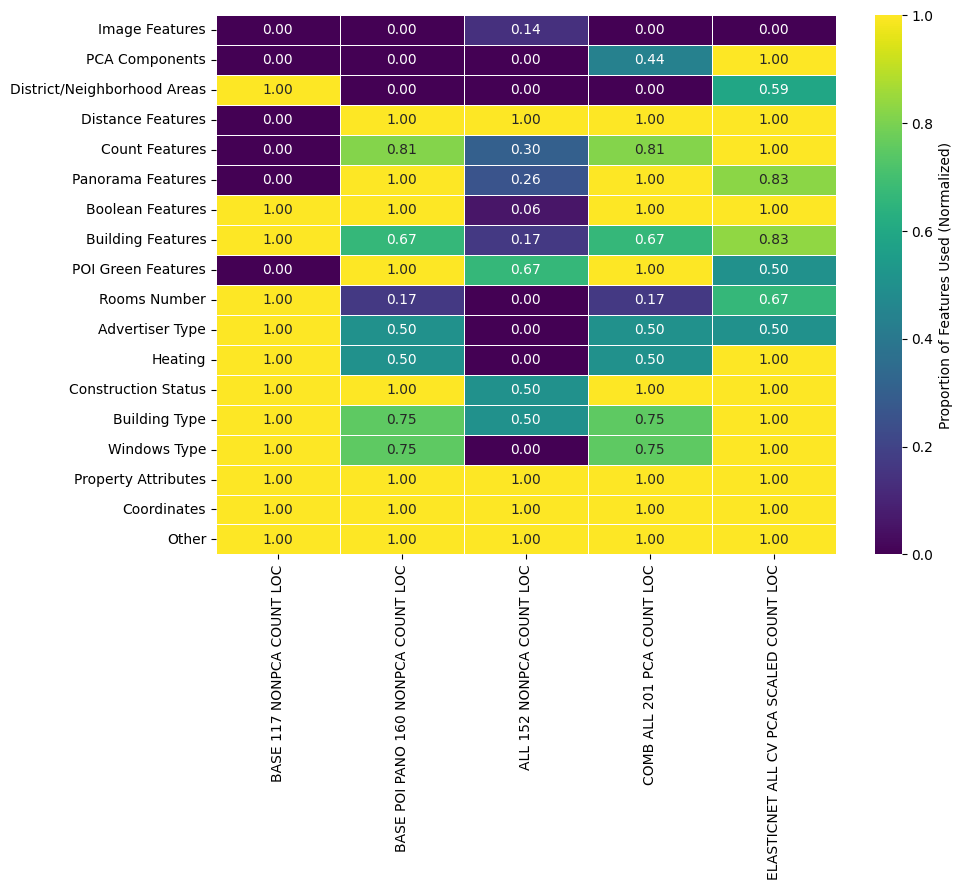

In [27]:
category_usage_normalized = category_usage.div(category_usage.max(axis=1), axis=0)

print("\nNormalized Category Usage (each row divided by its max):")
display(category_usage_normalized)

# --- 3. Plot the Normalized Data as a Heatmap ---
plt.figure(figsize=(10, 7)) # Adjust figure size for better readability of the heatmap
sns.heatmap(
    category_usage_normalized[['BASE 117 NONPCA COUNT LOC', 'BASE POI PANO 160 NONPCA COUNT LOC',
                               'ALL 152 NONPCA COUNT LOC', 'COMB ALL 201 PCA COUNT LOC',
                               'ELASTICNET ALL CV PCA SCALED COUNT LOC']],
    annot=True,      # Show the numerical values on the heatmap
    fmt=".2f",       # Format annotations to two decimal places
    cmap="viridis",  # Choose a color map (viridis, plasma, coolwarm, etc.)
    linewidths=.5,   # Add lines between cells
    cbar_kws={'label': 'Proportion of Features Used (Normalized)'} # Color bar label
)
plt.show()
